import all needed libraries
--

In [90]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from os import listdir
from os.path import isfile, join
%matplotlib inline


ALL Global varibale and path to KITTI dataset
--

In [91]:
## Dataset paths ##
dataset_path = 'dataset/sequences/09/image_0/'
dataset_pose_path = "dataset/poses/09.txt"
## Camera intrinsic paramters ##
k = np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02],
     [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02],
     [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]], dtype=np.float32)
## Min feature number to track ## 
kMinNumFeature = 3000
## Create empty image to draw trajectory ## 
traj = np.zeros((600, 600, 3), dtype=np.uint8)
x_loc = []
z_loc = []
cur_R = None
cur_t = None

Read dataset from path folder to list of image paths
--

In [92]:
def Read_dataset(dataset_path):
    seq00_list = [dataset_path+f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
    seq00_list.sort()
    return seq00_list

Read Ground truth pose of the vehicle
--

In [93]:
def Read_gt_trajectory(dataset_pose_path):
    file_09 = open(dataset_pose_path,"r") 
    lines = file_09.readlines()
    x = []
    y = []
    z = []
    for i in lines:
        x.append(i.split(' ')[3])
        y.append(i.split(' ')[7])
        z.append(i.split(' ')[11])
    file_09.close()
    gt_trajectory =  np.stack((x, y, z)).astype(np.float32)
    return gt_trajectory

**Feature Tracking function, take two Consecutive frames and fetures to track**
--                           


In [94]:
######################################################################
#    image_ref: frame at (t-1)                                       #
#    image_cur: frame at (t)                                         #
#    px_ref: feature at the frame (t-1)                              # 
######################################################################

def featureTracking(image_ref, image_cur, px_ref):
    lk_params = dict(winSize  = (21, 21), 
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    kp2, st, err = cv2.calcOpticalFlowPyrLK(image_ref, image_cur, px_ref, None, **lk_params)  

    st = st.reshape(st.shape[0])
    kp1 = px_ref[st == 1]
    kp2 = kp2[st == 1]

    return kp1, kp2

Since this is a monocular visual odometry, The algorithme can not scale the movement (unit of the distance) so we need to find the right scale from the ground truth trajectory
--

In [95]:
######################################################################
#    gt_trajectory: Ground truth trajectory matrix                   #
#    frame_id: frame number                                          #
######################################################################
def getAbsoluteScale(gt_trajectory, frame_id):  
    x_prev = float(gt_trajectory[0, frame_id-1])
    y_prev = float(gt_trajectory[1, frame_id-1])
    z_prev = float(gt_trajectory[2, frame_id-1])
    x = float(gt_trajectory[0, frame_id])
    y = float(gt_trajectory[1, frame_id])
    z = float(gt_trajectory[2, frame_id])
    return np.sqrt((x - x_prev)*(x - x_prev) + (y - y_prev)*(y - y_prev) + (z - z_prev)*(z - z_prev))

In [96]:
def process_first_frames(first_frame, second_frame, k):
    det = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
    # det = cv2.ORB_create(nfeatures=2000)
    kp1 = det.detect(first_frame)
    kp1 = np.array([x.pt for x in kp1], dtype=np.float32)

    kp1, kp2 = featureTracking(first_frame, second_frame, kp1)
    E, mask = cv2.findEssentialMat(kp2, kp1, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, kp2, kp1, k)
    kp1 = kp2
    return kp1, R, t

Call init function to start the main loop
--
Read dataset image.
Read dataset ground truth pose.
process first two image to start the main loop.

In [97]:
seq00_list = Read_dataset(dataset_path)
gt_trajectory = Read_gt_trajectory(dataset_pose_path)
first_frame = cv2.imread(seq00_list[0], 0)
second_frame = cv2.imread(seq00_list[1], 0)
kp1, cur_R, cur_t = process_first_frames(first_frame, second_frame, k)
last_frame = second_frame

main loop
--

In [98]:
## main loop ## 
for i in range(len(seq00_list)):
    ## read the new frame from the image paths list ## 
    new_frame = cv2.imread(seq00_list[i], 0)
    ## track the feature movement from prev frame to current frame ## 
    kp1, kp2 = featureTracking(last_frame, new_frame, kp1)
    ## find the rotation and translation matrix ##
    E, mask = cv2.findEssentialMat(kp2, kp1, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, kp2, kp1, k)
    ## find the change of the feature location ## 
    change = np.mean(np.abs(kp2 - kp1))
    ## find the scale of the movemnt from the ground truth trajectory ## 
    absolute_scale = getAbsoluteScale(gt_trajectory, i)
    ## check if the vehicle not moving by check the change value ## 
    if change > 5:
        ## accumulate the translation and rotation to find the X, Y, Z locations ## 
        cur_t = cur_t + absolute_scale * cur_R.dot(t)
        cur_R = R.dot(cur_R)
    ## if the number of detect features below threshold value recaulc the feature ## 
    if(kp1.shape[0] < kMinNumFeature):
        det = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
        kp2 = det.detect(new_frame)
        kp2 = np.array([x.pt for x in kp2], dtype=np.float32)
    ## Get ready for the next loop ##
    kp1 = kp2
    last_frame = new_frame
    ## start after the first two frames ##
    if i > 2 :
        x, y, z = cur_t[0], cur_t[1], cur_t[2]
    else:
        x, y, z = 0.0, 0.0, 0.0
    ## save x, z loc ##
    x_loc.append(x)
    z_loc.append(z)
    ## Draw trajectory ##
    draw_x, draw_y = int(x)+290, int(z)+90
    true_x, true_y = int(gt_trajectory[0, i])+290, int(gt_trajectory[2, i])+90
    cv2.circle(traj, (draw_x,draw_y), 1, (0,0,255), 1)
    cv2.circle(traj, (true_x,true_y), 1, (0,255,0), 2)
    cv2.rectangle(traj, (10, 20), (600, 60), (0,0,0), -1)
    text = "Coordinates: x=%2fm y=%2fm z=%2fm"%(x,y,z)
    cv2.putText(traj, text, (20,40), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8)
    cv2.imshow('Road facing camera', new_frame)
    cv2.imshow('Trajectory', traj)
    # Close the frame
    if cv2.waitKey(1) & 0xff == ord('q'):
        break
    
# Release and Destroy
cv2.destroyAllWindows()
cv2.imwrite('map.png', traj)

True

In [99]:
## find mean Error ##
Error = np.mean((gt_trajectory[0] - x_loc)**2 + (gt_trajectory[2] - z_loc)**2)
print("Mean Error: "+ str(Error))

Mean Error: [53.13394528]


Plot Result X Z location
--

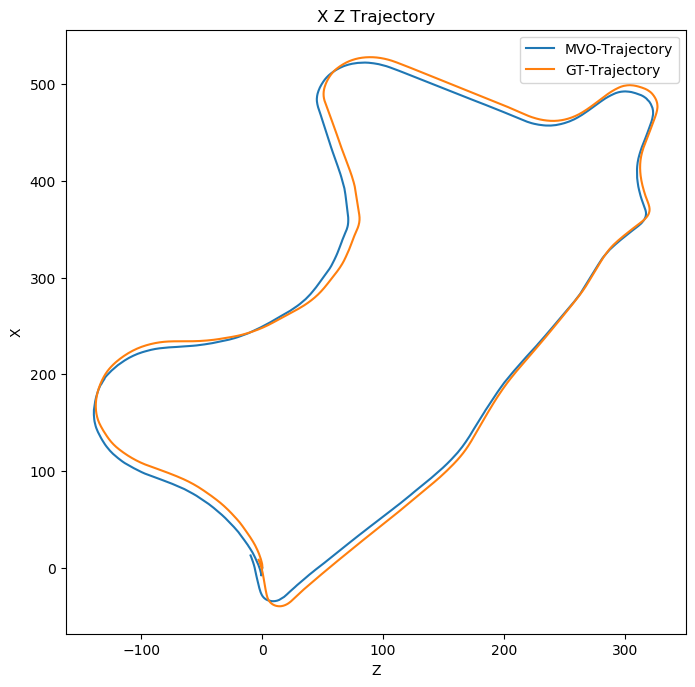

In [100]:
## Plot Result ##
plt.figure(figsize=(8, 8), dpi=100)
plt.title("X Z Trajectory")
plt.ylabel("X")
plt.xlabel("Z")
plt.plot(x_loc, z_loc, label="MVO-Trajectory")
plt.plot(gt_trajectory[0], gt_trajectory[2], label="GT-Trajectory")
plt.legend()
plt.show()